####Import Library
Please to run the code:
1. !pip install fasttext
2. nltk.download('all') *after import nltk*

In [2]:
import pandas as pd
import nltk
import re
import seaborn as sns
import matplotlib.pyplot as plt
import fasttext

from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from sklearn.metrics import roc_auc_score

####Check Data

In [4]:
df = pd.read_csv('https://drive.google.com/uc?id=1ogkVzRs9HptE5nY1dyiQUnB4DsBlFswS')
df.head(3)

,clean_text,is_depression
0,we understand that most people who reply immed...,1
1,welcome to r depression s check in post a plac...,1
2,anyone else instead of sleeping more when depr...,1


Dimension of data: 
(7731, 2)

Number of null status in data: 
clean_text       0
is_depression    0
dtype: int64

Values count


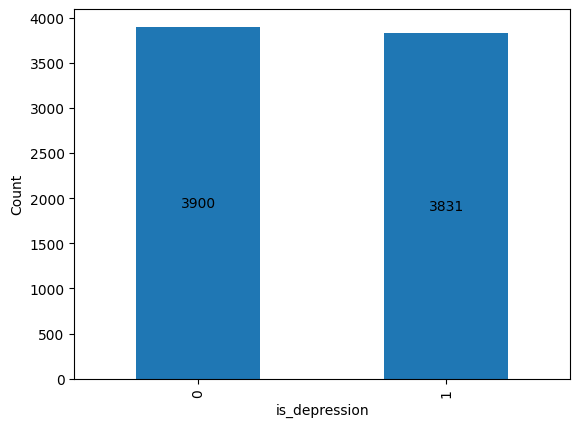

In [5]:
print(f'Dimension of data: \n{df.shape}\n')
print(f'Number of null status in data: \n{df.isna().sum()}\n')

ax = df['is_depression'].value_counts().plot.bar()
ax.set_ylabel('Count')

print('Values count')
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height:.0f}', (x + width/2, y + height/2), ha='center', va='center')

####Data Preprocessing

In [6]:
corpus = []

def clean_text(text):
     text = text.lower()
     text = re.sub(r'[^a-zA-Z0-9 \s]', '', text)
     text = re.sub(r'\s+', ' ', text)
     return text

for i, text in enumerate(df['clean_text']):
    r = clean_text(text)
    r = r.split()
    r = [word for word in r if word not in stopwords.words('english')]
    r = ' '.join(r)
    corpus.append(r)

df['clean_text'] =corpus

In [7]:
df = df.drop_duplicates(subset='clean_text', keep='first')

drop_indices = []

for i, text in enumerate(df['clean_text']):
    if len(text.split()) == 1 and len(text.split()[0]) < 10:
        drop_indices.append(i)

df = df.drop(index=drop_indices)
df = df.reset_index(drop=True)

In [8]:
df['is_depression'] = "__label__" + df['is_depression'].astype(str)
df['text_label'] = df['is_depression'] + ' ' + df['clean_text']

####Training Model

In [9]:
train, test = train_test_split(df, test_size = 0.2)

import os

def overwrite_csv(file_name, dataframe, columns):
    if os.path.exists(file_name):
        os.remove(file_name)

    dataframe.to_csv(file_name, columns=columns, index=False, header=False)
    print(f"File {file_name} had been changed by new file")

overwrite_csv("train", train, ["text_label"])
overwrite_csv("test", test, ["text_label"])

File train had been changed by new file
File test had been changed by new file


In [10]:
import time

# Waiting time for the file create/re-create
time.sleep(7)

In [11]:
# Train the model
model = fasttext.train_supervised('train')

# Function to display training results
def print_results(sample_size, precision, recall):
    print(f"Sample size: {sample_size}")
    print(f"Precision  : {round(precision, 2)}")
    print(f"Recall     : {round(recall, 2)}")

# Apply the function to test results
print_results(*model.test('test'))

Sample size: 1515
Precision  : 0.96
Recall     : 0.96


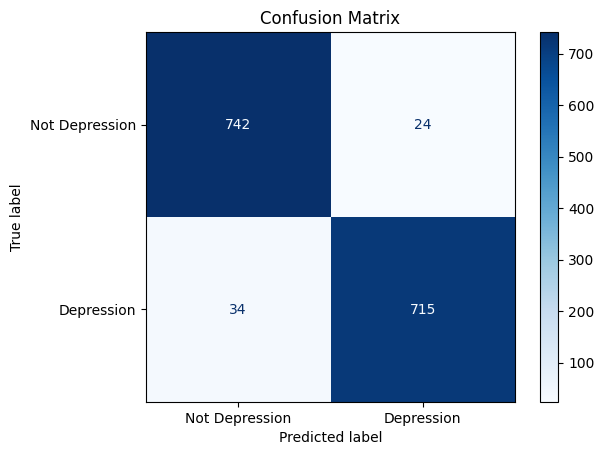

In [12]:
test_texts = test['clean_text'].tolist()
predictions = model.predict(test_texts)
predicted_labels = [label[0] for label in predictions[0]]
true_labels = test['is_depression'].astype(str).tolist()
cm = confusion_matrix(true_labels, predicted_labels, labels=["__label__0", "__label__1"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Depression", "Depression"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [13]:
def predict_text(text):
    if isinstance(text, str):
        text = [clean_text(text)]
    labels, probabilities = model.predict(text)
    print("Predicted Label:", labels[0][0])
    print("Probability:", probabilities[0][0])

user_input = input("Input your text: ")
predict_text(user_input)

Input your text: Some days feel like a never-ending loop of "fuck this" and "why even bother"—and you just keep breathing, pretending it's fine.
Predicted Label: __label__1
Probability: 0.93609494
